# Install cuml

In [ ]:
!pip uninstall -y cupy-cuda11x
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12 cuml-cu12
!pip install pandas==2.2.2

In [2]:
#!pip uninstall -y cupy-cuda11x

In [3]:
import cuml
print(cuml.__version__)

24.10.00


# Imports

In [5]:
import numpy as np
import seaborn as sns
import cupy as cp
import matplotlib.pyplot as plt
from cuml.svm import LinearSVC
from cuml.linear_model import Ridge, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dataset

In [17]:
def load_mnist_data(selected_classes=[3, 8], noise_level=0, subsample_size=None):
    # Load MNIST dataset
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y = mnist.data, mnist.target.astype(int)

    # Filter classes for binary classification
    mask = np.isin(y, selected_classes)
    X, y = X[mask], y[mask]


    # Add label noise
    if noise_level > 0:
        n_noisy = int(noise_level * len(y))
        noisy_indices = np.random.choice(len(y), n_noisy, replace=False)
        y[noisy_indices] = np.random.choice(selected_classes, n_noisy)

    # Subsample the dataset
    if subsample_size is not None and subsample_size < len(y):
        subsample_indices = np.random.choice(len(y), int(subsample_size * X.shape[0]), replace=False)
        X, y = X[subsample_indices], y[subsample_indices]

    X = StandardScaler().fit_transform(X)
    return train_test_split(X, y, train_size=0.8, random_state=42)

# ReLU features

In [18]:
def generate_random_relu_features(X, num_features, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    weights = np.random.randn(X.shape[1], num_features)
    biases = np.random.randn(num_features)

    random_features = np.maximum(0, X @ weights + biases)
    return random_features

In [19]:
def to_gpu_array(np_array):
    return cp.asarray(np_array)

# SVM training

In [21]:
def train_and_evaluate_linear_svm(X_train, y_train, X_test, y_test):
    """
    Trains a linear SVM and evaluates on training and testing datasets.
    Logs accuracy, MSE, and squared norm for both training and testing.
    """
    # Convert data to GPU-compatible format
    X_train_gpu = to_gpu_array(X_train)
    y_train_gpu = to_gpu_array(y_train)
    X_test_gpu = to_gpu_array(X_test)
    y_test_gpu = to_gpu_array(y_test)

    # Train Linear SVM
    svm = LinearSVC(C=64, max_iter=1000)
    svm.fit(X_train_gpu, y_train_gpu)

    # Predictions
    y_train_pred = svm.predict(X_train_gpu)
    y_test_pred = svm.predict(X_test_gpu)

    # Train/Test Accuracy
    train_accuracy = accuracy_score(cp.asnumpy(y_train_gpu), cp.asnumpy(y_train_pred))
    test_accuracy = accuracy_score(cp.asnumpy(y_test_gpu), cp.asnumpy(y_test_pred))

    # Squared norm of weights
    squared_norm = np.sum(svm.coef_.get() ** 2)

    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        #'train_mse': train_mse,
        #'test_mse': test_mse,
        'train_squared_norm': squared_norm,
        'test_squared_norm': squared_norm
    }


# Plotting

In [22]:
def plot_results_combined(feature_counts, all_results, noise_levels, model_type):
    # Set up the color palettes
    train_palette = sns.color_palette("Blues", len(noise_levels))
    test_palette = sns.color_palette("Oranges", len(noise_levels))

    # Set up the subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle(model_type, fontsize=24)

    # Metrics to plot
    metrics = ['accuracy',
               'squared_norm']
    titles = [
        'Accuracy',
        'Squared Norm of Weights'
    ]
    ylabels = [
        'Accuracy',
        'Squared Norm'
    ]

    for row, data_type in enumerate(['train', 'test']):
        palette = train_palette if data_type == 'train' else test_palette

        for col, metric in enumerate(metrics):
            ax = axs[row, col]

            for idx, noise_level in enumerate(noise_levels):
                y_values = all_results[noise_level][f'{data_type}_{metric}']
                label = f'Noise {noise_level * 100:.0f}% ({data_type.capitalize()})'
                ax.plot(
                    feature_counts, y_values, marker='o', label=label, color=palette[idx]
                )

            ax.set_xscale('log')
            ax.set_xlabel('Number of Random ReLU Features')
            ax.set_ylabel(ylabels[col])
            ax.set_title(f'{titles[col]} ({data_type.capitalize()})')
            ax.grid(True)
            ax.legend()

    plt.tight_layout()
    plt.show()

# SVM experiment

In [23]:
def mnist_relu_feature_svm_experiment(feature_counts, noise_level=0, subsample_size=None):
    X_train, X_test, y_train, y_test = load_mnist_data(noise_level=noise_level, subsample_size=subsample_size)

    metrics = {
        'train_accuracy': [],
        'test_accuracy': [],
        #'train_mse': [],
        #'test_mse': [],
        'train_squared_norm': [],
        'test_squared_norm': []
    }

    for num_features in feature_counts:
        # Generate random ReLU features
        X_train_relu = generate_random_relu_features(X_train, num_features, random_seed=42)
        X_test_relu = generate_random_relu_features(X_test, num_features, random_seed=42)

        # Train and evaluate model
        results = train_and_evaluate_linear_svm(X_train_relu, y_train, X_test_relu, y_test)

        # Collect metrics
        for key in metrics:
            metrics[key].append(results[key])

    return metrics


In [24]:
feature_counts = np.logspace(2.0, 4.2, num=15).astype(np.int32)
noise_levels = [0, 0.1, 0.2, 0.3]
results = {}

for noise_level in noise_levels:
    print(f"Running experiment with {noise_level * 100:.0f}% noisy labels...")
    results[noise_level] = mnist_relu_feature_svm_experiment(feature_counts, noise_level=noise_level, subsample_size=1.0)

Running experiment with 0% noisy labels...
Running experiment with 10% noisy labels...
Running experiment with 20% noisy labels...
[W] [07:34:24.816458] L-BFGS: max iterations reached
[W] [07:34:24.816835] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
Running experiment with 30% noisy labels...
[W] [07:37:22.974623] L-BFGS: max iterations reached
[W] [07:37:22.976066] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [07:37:32.032411] L-BFGS: max iterations reached
[W] [07:37:32.032816] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


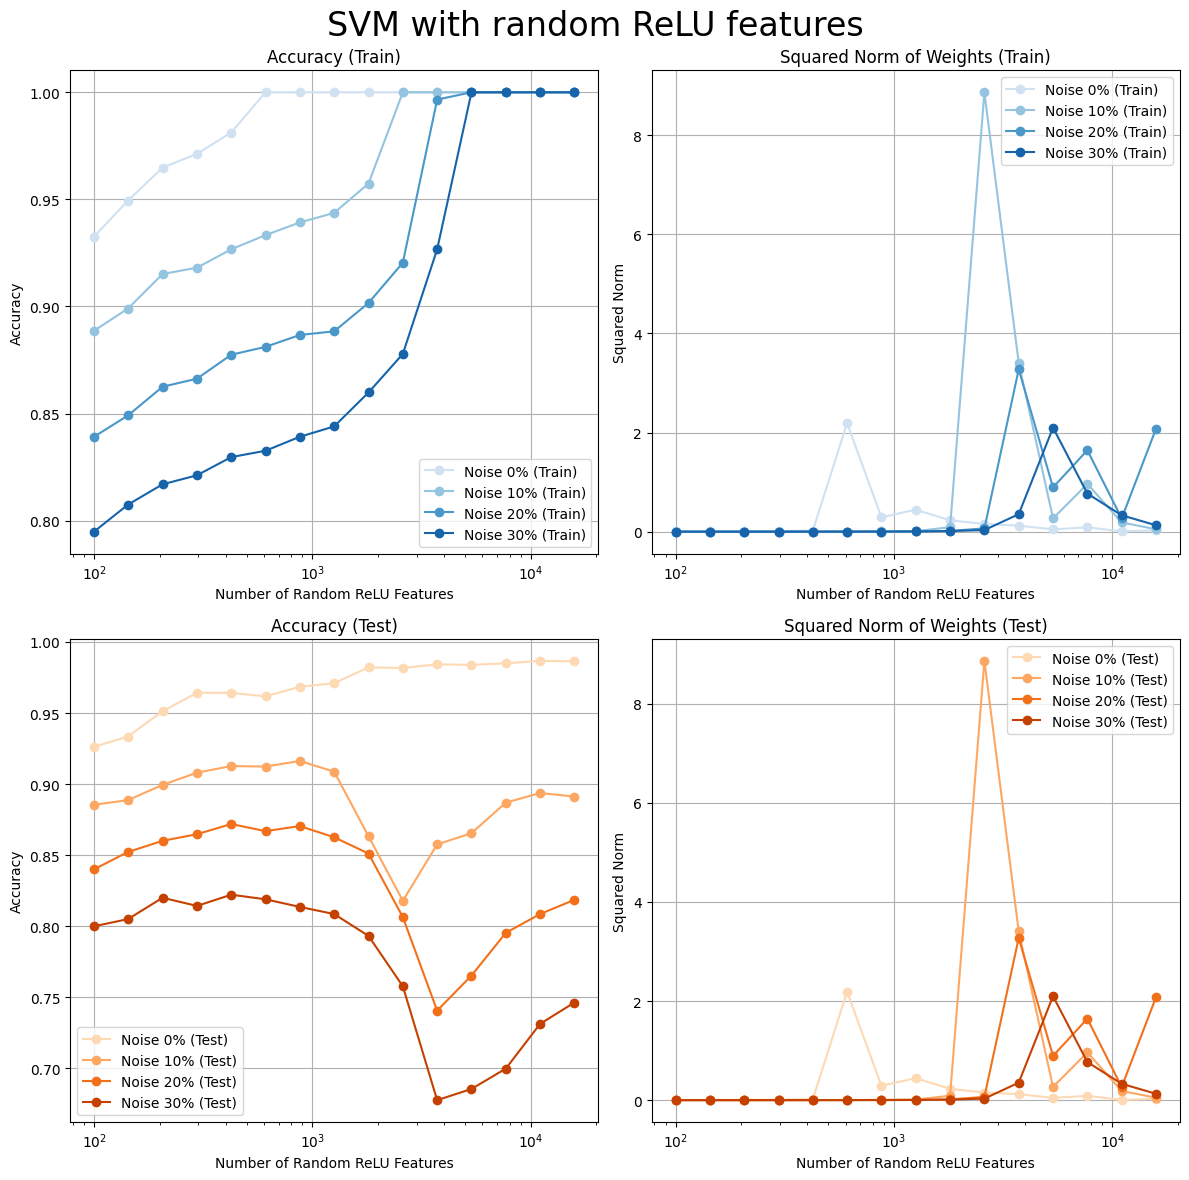

In [25]:
plot_results_combined(feature_counts, results, noise_levels, "SVM with random ReLU features")

# Least Squares training

In [26]:
def train_and_evaluate_ls_model(X_train, y_train, X_test, y_test):
    """
    Trains an LS model (ridge regression) and evaluates metrics.
    """
    # Convert data to GPU-compatible format
    X_train_gpu = to_gpu_array(X_train)
    y_train_gpu = to_gpu_array(y_train)
    X_test_gpu = to_gpu_array(X_test)
    y_test_gpu = to_gpu_array(y_test)

    # Train Ridge Regression Model
    model = LinearRegression(fit_intercept=False, copy_X=False)
    model.fit(X_train_gpu, y_train_gpu)

    # Predictions
    y_train_pred = model.predict(X_train_gpu)
    y_test_pred = model.predict(X_test_gpu)

    # Thresholding for classification
    selected_classes = np.unique(cp.asnumpy(y_train_gpu))
    threshold = 0.5 * (selected_classes[0] + selected_classes[1])
    y_train_pred_class = np.where(y_train_pred > threshold, selected_classes[1], selected_classes[0])
    y_test_pred_class = np.where(y_test_pred > threshold, selected_classes[1], selected_classes[0])

    # Metrics
    train_accuracy = accuracy_score(cp.asnumpy(y_train_gpu), cp.asnumpy(y_train_pred_class))
    test_accuracy = accuracy_score(cp.asnumpy(y_test_gpu), cp.asnumpy(y_test_pred_class))
    squared_norm = np.sum(model.coef_.get() ** 2)

    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_squared_norm': squared_norm,
        'test_squared_norm': squared_norm
    }


# Least Squares experiment

In [27]:
def mnist_relu_feature_ls_experiment(feature_counts, noise_level=0, subsample_size=None):
    """
    Runs LS experiments with ReLU features, collects metrics, and returns results.
    """
    X_train, X_test, y_train, y_test = load_mnist_data(noise_level=noise_level, subsample_size=subsample_size)

    metrics = {
        'train_accuracy': [],
        'test_accuracy': [],
        'train_squared_norm': [],
        'test_squared_norm': []
    }

    for num_features in feature_counts:
        X_train_relu = generate_random_relu_features(X_train, num_features, random_seed=42)
        X_test_relu = generate_random_relu_features(X_test, num_features, random_seed=42)

        results = train_and_evaluate_ls_model(X_train_relu, y_train, X_test_relu, y_test)

        for key in metrics:
            metrics[key].append(results[key])

    return metrics


In [28]:
feature_counts = np.logspace(2.0, 3.75, num=20).astype(np.int32)
noise_levels = [0, 0.1, 0.2, 0.3]
results = {}

for noise_level in noise_levels:
    print(f"Running experiment with {noise_level * 100:.0f}% noisy labels...")
    results[noise_level] = mnist_relu_feature_ls_experiment(feature_counts, noise_level=noise_level, subsample_size=0.2)

Running experiment with 0% noisy labels...
Running experiment with 10% noisy labels...
Running experiment with 20% noisy labels...
Running experiment with 30% noisy labels...


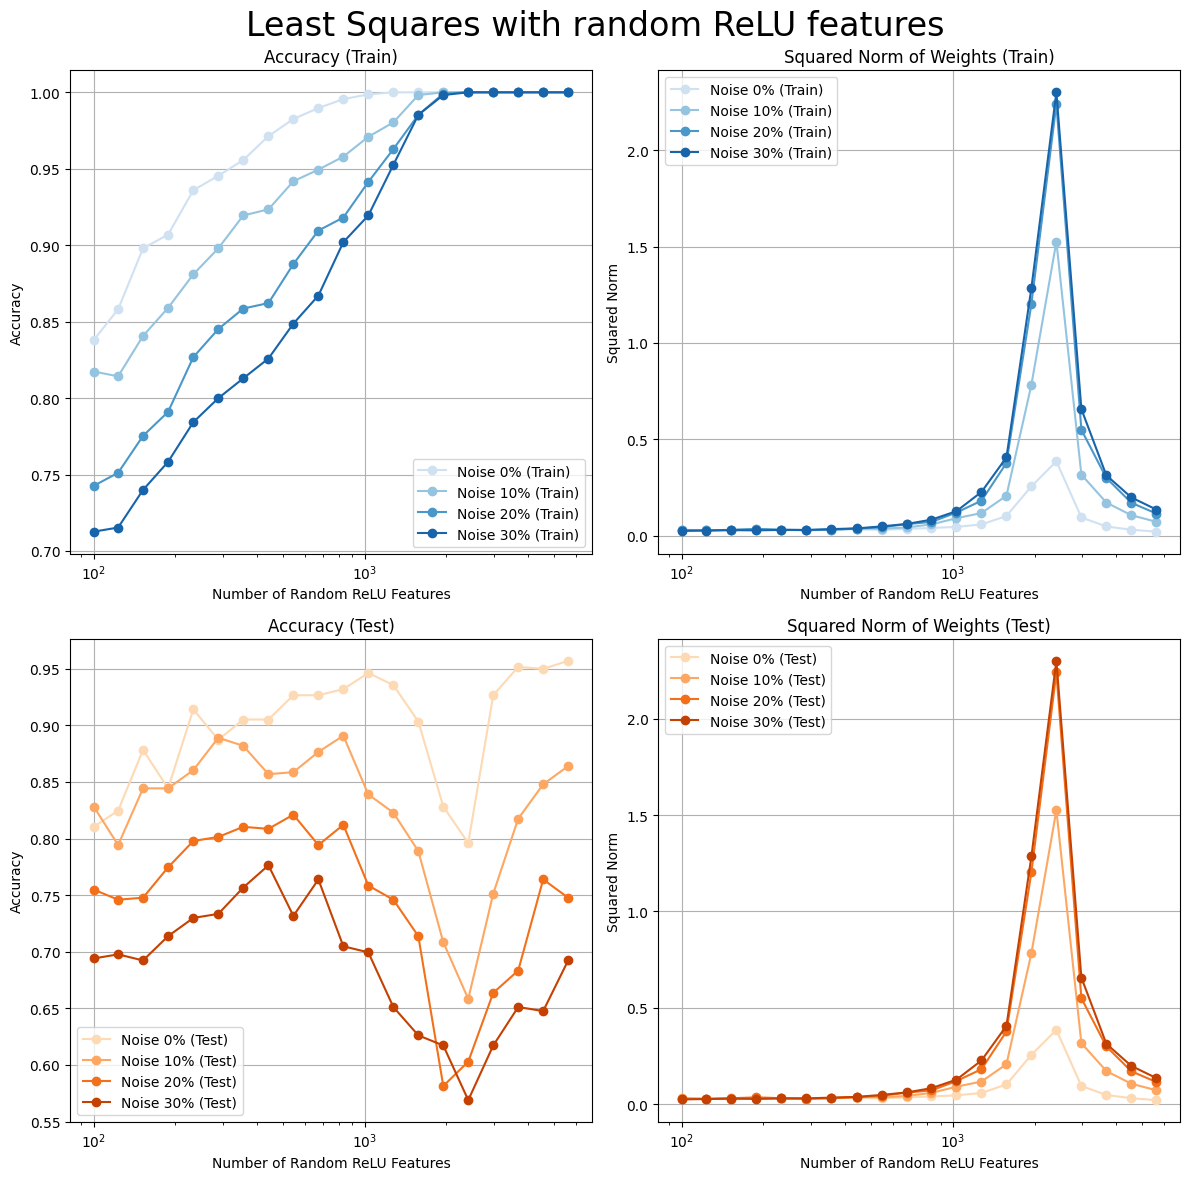

In [29]:
plot_results_combined(feature_counts, results, noise_levels, "Least Squares with random ReLU features")